<a href="https://colab.research.google.com/github/OUCTheoryGroup/colab_demo/blob/master/07_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 变分自编码器 （Variational Auto-Encoder， VAE）

VAE的示意图如下所示：

![VAE示意图](https://raw.githubusercontent.com/summitgao/ImageGallery/master/20200227190742.jpg)

通常会拿 VAE 跟 GAN 比较，的确，它们两个的目标基本是一致的：希望构建一个从隐变量 Z 生成目标数据 X 的模型，但是实现上有所不同。

下面结合代码来分析。首先是引入基本的库文件，以及定义一个用于显示图像的函数。

In [0]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

# Displaying routine
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(6, 2))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], 'gray')
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(6, 2))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N], 'gray')
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

接下来是定义 train_loader 和 test_loader

In [0]:
# Set random seeds
torch.manual_seed(1)
torch.cuda.manual_seed(1)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

接下来就是定义VAE模型。
包括 编码器 和 解码器，维度变化细节为：
- 编码器： 784 ==> 40 ==> 40
- 解码器： 20 ==> 40 ==> 784

这里可以看，编码器输出数据维度是 40 ，但解码器输入的数据维度是 20。 中间连接有一个 reparameterise 函数，即重参数，图示如下：

![重参数](https://raw.githubusercontent.com/summitgao/ImageGallery/master/20200227191909.jpg)

其中原理的话，大家可以看看知乎文章《[变分自编码器VAE：原来是这么一回事](https://zhuanlan.zhihu.com/p/34998569)》



In [0]:
d = 20

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2))
        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Sigmoid())

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar

model = VAE().to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        x_hat, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

====> Epoch: 1 Average loss: 188.2892
====> Test set loss: 135.9683
====> Epoch: 2 Average loss: 132.5792
====> Test set loss: 116.0247
====> Epoch: 3 Average loss: 121.1741
====> Test set loss: 109.1417
====> Epoch: 4 Average loss: 116.2666
====> Test set loss: 105.1034
====> Epoch: 5 Average loss: 113.3771
====> Test set loss: 104.1403
====> Epoch: 6 Average loss: 111.5197
====> Test set loss: 101.6781
====> Epoch: 7 Average loss: 110.1940
====> Test set loss: 100.5811
====> Epoch: 8 Average loss: 109.2270
====> Test set loss: 100.0496
====> Epoch: 9 Average loss: 108.4431
====> Test set loss: 98.6812
====> Epoch: 10 Average loss: 107.7578
====> Test set loss: 98.2803


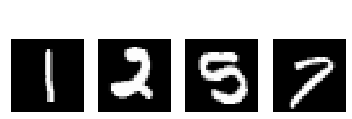

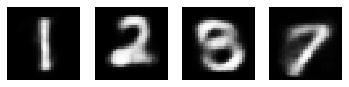

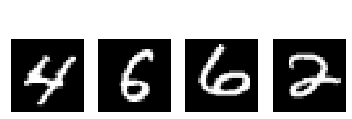

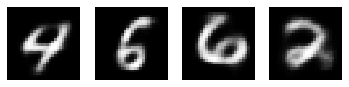

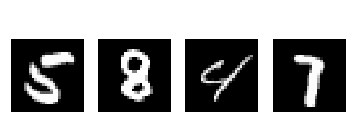

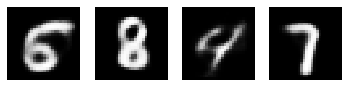

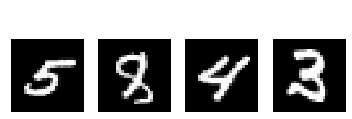

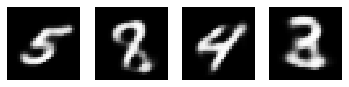

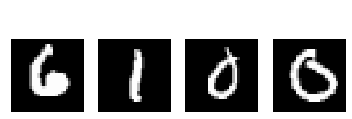

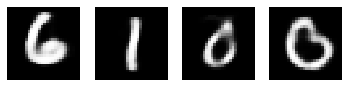

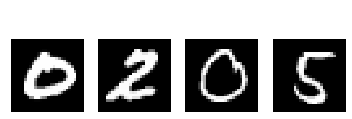

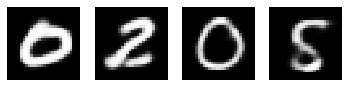

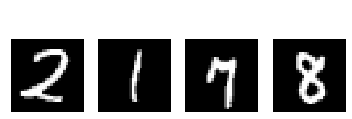

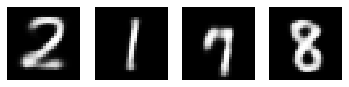

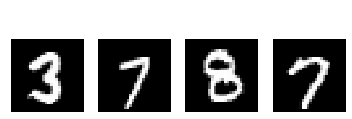

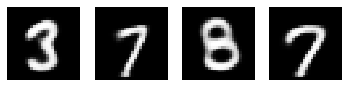

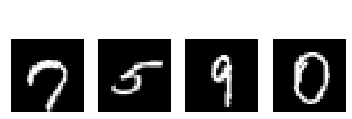

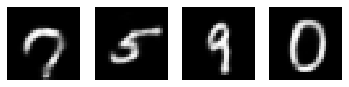

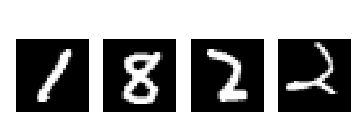

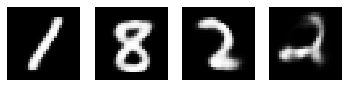

In [28]:
# Training and testing the VAE
epochs = 10
for epoch in range(1, epochs + 1):
    # Training
    model.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        # ===================forward=====================
        x_hat, mu, logvar = model(x)
        loss = loss_function(x_hat, x, mu, logvar)
        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')
    
    # Testing
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, _ in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
    # ===================log========================
    test_loss /= len(test_loader.dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 1, f'Epoch {epoch}')

在 VAE 训练完成以后，我们输入一组噪声，试试样本生成的效果。

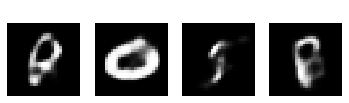

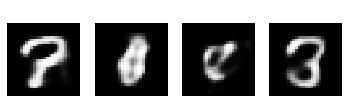

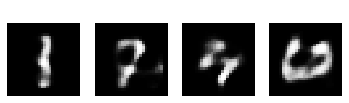

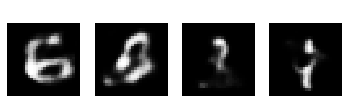

In [29]:
N = 16
z = torch.randn((N, d)).to(device)
sample = model.decoder(z)
display_images(None, sample, N // 4, count=True)

可以看到，上面的代码基本完成了输入一组随机噪声，生成数字的任务，但是效果差强人意。